In [47]:
import os
import numpy as np
import pandas as pd
import urllib
import zipfile
import xmltodict
from IPython.display import display
import praw
import os
from itertools import repeat

REDDIT_LIMIT = None
SET1 = 'familyguy'
SET2 = 'fisforfamily'
REDDIT_PICKLE_PATH = os.path.join("data", "reddit.pickle")
TRAIN_TEST_RATIO = 0.3 # proportion of test data

if not os.path.isfile(REDDIT_PICKLE_PATH):
    is_empty = lambda s: s == None or len(s) == 0
    reddit = praw.Reddit(client_id='JBNnBw1JwQk-3w',
                         client_secret='f4wT7DgjxPxcpm2vGAuXIr_4xhc',
                         user_agent='my user agent')

    set1 = reddit.subreddit(SET1)
    set2 = reddit.subreddit(SET2)

    set1_submissions = list(set1.new(limit=REDDIT_LIMIT))
    set1_submissions = filter(lambda s: not is_empty(s.selftext), set1_submissions)

    set2_submissions = list(set2.new(limit=REDDIT_LIMIT))
    set2_submissions = filter(lambda s: not is_empty(s.selftext), set2_submissions)

    allsubmissions = list(zip(repeat(SET1), set1_submissions)) + list(zip(repeat(SET2), set2_submissions))
    df = pd.DataFrame({"series" : list(map(lambda s: s[0], allsubmissions)), "selftext" : list(map(lambda s: s[1].selftext, allsubmissions))})
    df.to_pickle(REDDIT_PICKLE_PATH)
else:
    df = pd.read_pickle(REDDIT_PICKLE_PATH)

display(df.head())

,series,selftext
0,familyguy,Which episode is it where Peters going somewhe...
1,familyguy,[https://www.youtube.com/watch?v=ud\_xC\_Dzemc...
2,familyguy,"What’s your favorite, episode you can sit down..."
3,familyguy,There is scene in family guy where peter says ...
4,familyguy,"OK, just watched an episode where Mayor West r..."


In [48]:
vc = df.series.value_counts()
vc

fisforfamily    462
familyguy       262
Name: series, dtype: int64

In [49]:
import spacy
from spacy.lang.en import STOP_WORDS
nlp = spacy.load("en_core_web_sm")
for word in nlp.Defaults.stop_words:
    for w in (word, word[0].upper() + word[1:], word.upper()):
        lex = nlp.vocab[w].is_stop = True
_ = nlp.disable_pipes("tagger", "parser", "ner")

In [50]:
ANALYSIS_FILE = "analysis.pickle"
ANALYSIS_PATH = os.path.join(DATA_PATH, ANALYSIS_FILE)

def analyze(speech):
    document = nlp(speech)
    token = [w.text for w in document]
    lemma = [w.lemma_ for w in document]
    return (token, lemma)
    
if not os.path.isfile(ANALYSIS_PATH):
    analysis = df.selftext.map(analyze)
    df["tokens"] = analysis.apply(lambda x: x[0])
    df["lemmata"] = analysis.apply(lambda x: x[1])
    df.to_pickle(ANALYSIS_PATH)
else:
    df = pd.read_pickle(ANALYSIS_PATH)

In [51]:
df.head()

,series,selftext,tokens,lemmata
0,familyguy,Which episode is it where Peters going somewhe...,"[Which, episode, is, it, where, Peters, going,...","[Which, episode, be, it, where, Peters, go, so..."
1,familyguy,[https://www.youtube.com/watch?v=ud\_xC\_Dzemc...,"[[, https://www.youtube.com/watch?v=ud\_xC\_Dz...","[[, https://www.youtube.com/watch?v=ud\_xC\_Dz..."
2,familyguy,"What’s your favorite, episode you can sit down...","[What, ’s, your, favorite, ,, episode, you, ca...","[what, ’s, your, favorite, ,, episode, you, ca..."
3,familyguy,There is scene in family guy where peter says ...,"[There, is, scene, in, family, guy, where, pet...","[There, be, scene, in, family, guy, where, pet..."
4,familyguy,"OK, just watched an episode where Mayor West r...","[OK, ,, just, watched, an, episode, where, May...","[OK, ,, just, watch, a, episode, where, Mayor,..."


In [52]:
from collections import Counter

def compute_word_index(speeches):
    sets = [set(speech) for speech in speeches]
    union = set.union(*sets)
    idx_2_word = [word for (index, word) in enumerate(union)]
    word_2_idx = {word:index for (index, word) in enumerate(union)}
    return (idx_2_word, word_2_idx)

def bag_of_words(speeches, index):
    return speeches.apply(lambda speech: {index[word]:1 for word in speech})

def count_words(speeches, index):
    return speeches.apply(lambda speech: {index[word]:count for (word, count) in Counter(speech).items()})

In [53]:
(words, index) = compute_word_index(df["lemmata"])
df["lemma_bow"] = bag_of_words(df["lemmata"], index)
df["lemma_counts"] = count_words(df["lemmata"], index)

In [54]:
df.iloc[0]

series                                                  familyguy
selftext        Which episode is it where Peters going somewhe...
tokens          [Which, episode, is, it, where, Peters, going,...
lemmata         [Which, episode, be, it, where, Peters, go, so...
lemma_bow       {4291: 1, 3828: 1, 3127: 1, 4451: 1, 385: 1, 5...
lemma_counts    {4291: 1, 3828: 1, 3127: 2, 4451: 1, 385: 1, 5...
Name: 0, dtype: object

In [55]:
from sklearn.model_selection import train_test_split
import scipy.sparse as sparse
import itertools

def dict_to_sparse(list_of_dicts, vocab_size):
    index_and_data = [(index, dictionary[index]) for dictionary in list_of_dicts for index in dictionary]
    index, data = zip(*index_and_data)
    lengths = [len(dictionary) for dictionary in list_of_dicts]
    row_pointers = list(itertools.accumulate([0] + lengths))
    return sparse.csr_matrix((data, index, row_pointers), shape=(len(list_of_dicts), vocab_size))

data = dict_to_sparse(df["lemma_counts"], len(index))
categories = df["series"].astype("category")
labels = categories.cat.codes

(0.7110091743119266, array([[ 16,  63],
        [  0, 139]]))

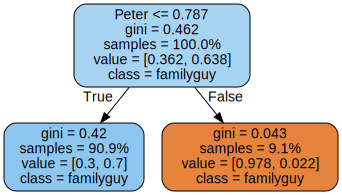

In [60]:
import sklearn.tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
import graphviz 

def make_decision_tree_classifier():
    return DecisionTreeClassifier(splitter="random", max_depth=1, criterion="gini")

def train_and_test(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    classifier = make_decision_tree_classifier()
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test(data, labels, test_size = TRAIN_TEST_RATIO)
display((accuracy, confusion))

def display_decision_tree(decision_tree_classifier):
    dot_data = sklearn.tree.export_graphviz(decision_tree_classifier, out_file=None,
                                            feature_names=words,
                                            class_names=categories,
                                            filled=True,
                                            proportion=True,
                                            rounded=True) 
    graph = graphviz.Source(dot_data) 
    display(graph)
    
display_decision_tree(classifier)

0.7247706422018348

array([[ 19,  60],
       [  0, 139]])

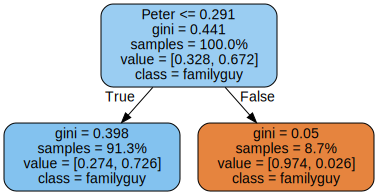

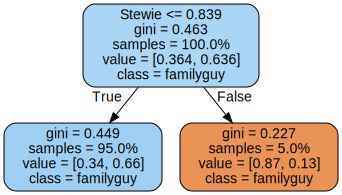

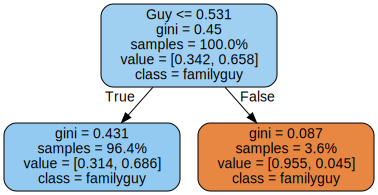

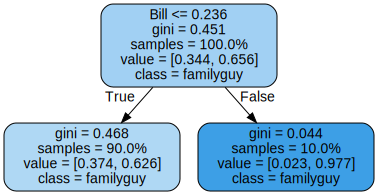

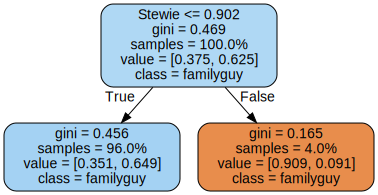

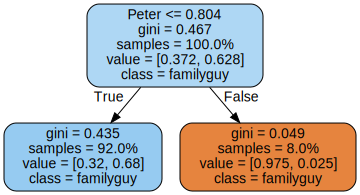

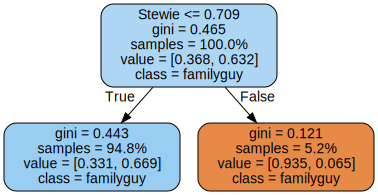

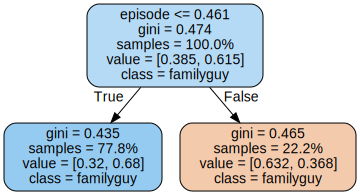

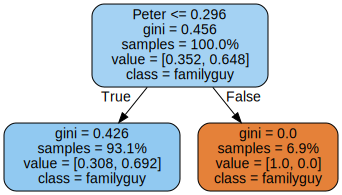

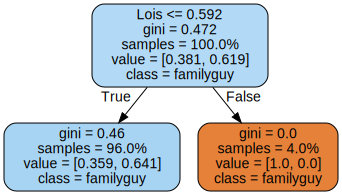

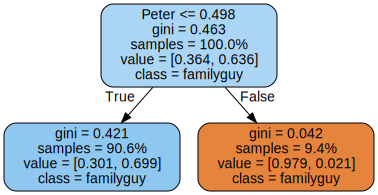

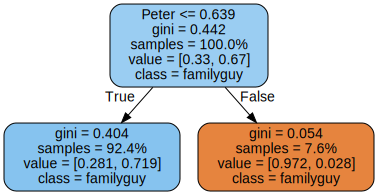

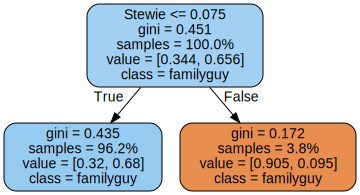

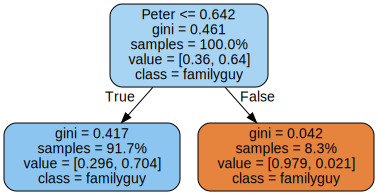

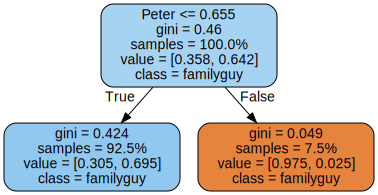

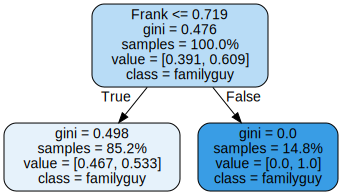

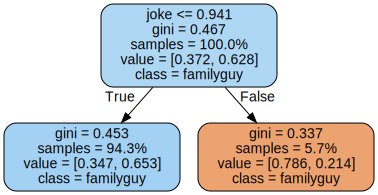

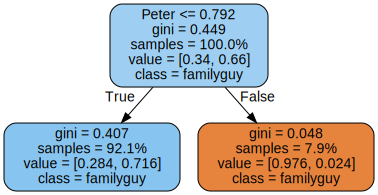

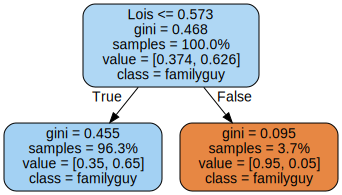

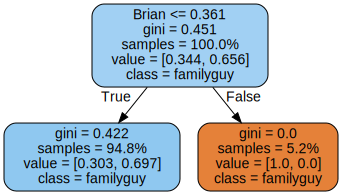

In [61]:
BOOST_FACTOR = 20

from sklearn.ensemble import BaggingClassifier


def train_and_test_bagged(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    ALL_CORES = -1
    classifier = BaggingClassifier(base_estimator = make_decision_tree_classifier(), n_estimators = BOOST_FACTOR, n_jobs=ALL_CORES)
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test_bagged(data, labels, test_size = TRAIN_TEST_RATIO)
display(accuracy, confusion)

for tree in classifier:
    display_decision_tree(tree)

0.7752293577981652

array([[ 45,  34],
       [ 15, 124]])

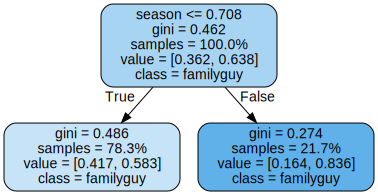

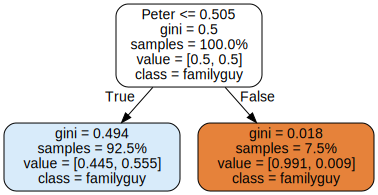

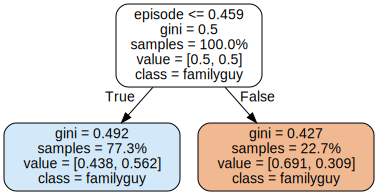

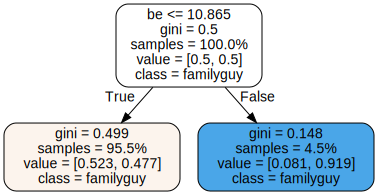

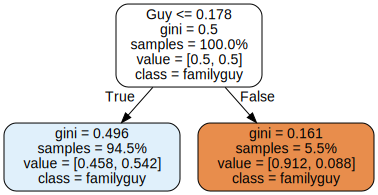

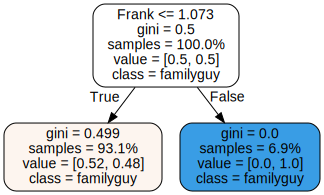

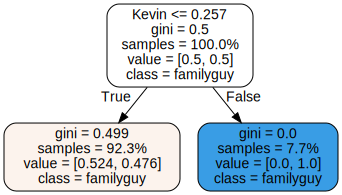

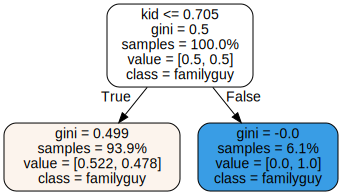

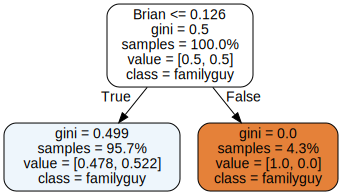

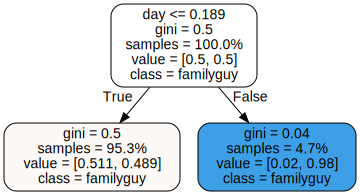

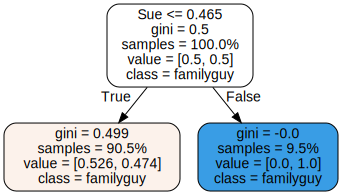

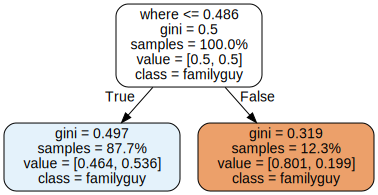

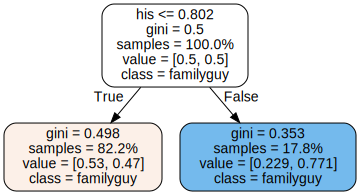

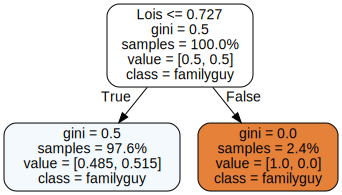

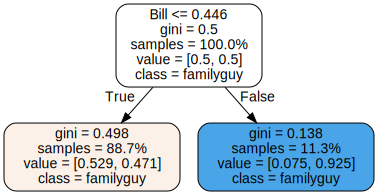

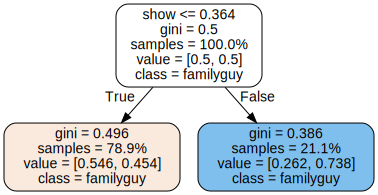

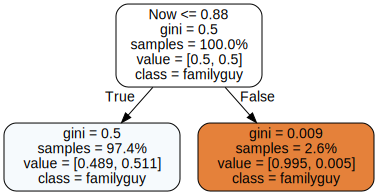

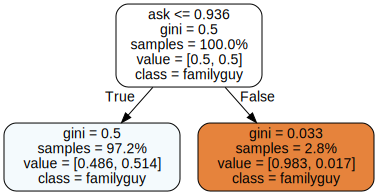

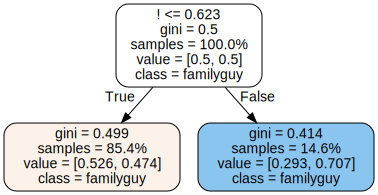

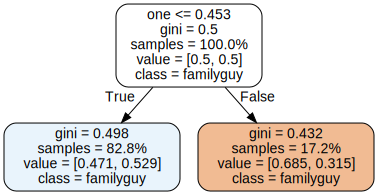

In [63]:
from sklearn.ensemble import AdaBoostClassifier

def train_and_test_boosted(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    classifier = AdaBoostClassifier(base_estimator = make_decision_tree_classifier(), n_estimators = BOOST_FACTOR)
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test_boosted(data, labels, test_size = TRAIN_TEST_RATIO)
display(accuracy, confusion)

for tree in classifier:
    display_decision_tree(tree)

0.7385321100917431

array([[ 23,  56],
       [  1, 138]])

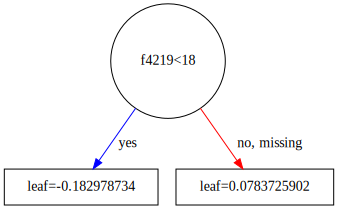

In [65]:
from xgboost import XGBClassifier
import xgboost
%matplotlib inline

def train_and_test_xgboost(data, labels, test_size):
    train_data, test_data, train_labels, test_labels = train_test_split(data, 
                                                    labels,
                                                    test_size = test_size,
                                                    stratify = labels)
    classifier = XGBClassifier(max_depth = 1, n_estimators = BOOST_FACTOR)
    classifier.fit(train_data, train_labels)
    
    predictions = classifier.predict(test_data)
    
    accuracy = np.mean(predictions == test_labels)
    confusion = confusion_matrix(test_labels, predictions)
    
    return (classifier, accuracy, confusion)

(classifier, accuracy, confusion) = train_and_test_xgboost(data, labels, test_size = TRAIN_TEST_RATIO)
display(accuracy, confusion)

#for tree in classifier:
#    display_decision_tree(tree)
dot_data = xgboost.to_graphviz(classifier)
graph = graphviz.Source(dot_data) 
display(graph)